In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc

In [ ]:
def generate_bits(num_bits, seed=42):
    """Generate random bits."""
    np.random.seed(seed)
    return np.random.randint(0, 2, num_bits)

In [1]:
def bpsk_modulation(bits):
    """
    BPSK modulation: map bits to symbols
    0 -> -1, 1 -> +1
    """
    return 2 * bits - 1


In [3]:
def awgn_channel(symbols, SNR_dB):
    """
    Additive White Gaussian Noise channel

    Returns:
    --------
    received : array
        Noisy received symbols
    noise_power : float
        Noise power (needed for soft decision LLR calculation)
    """
    SNR_linear = 10 ** (SNR_dB / 10)
    noise_power = 1 / SNR_linear
    noise = np.random.normal(0, np.sqrt(noise_power), len(symbols))
    received = symbols + noise
    return received, noise_power

In [4]:
def hard_decision_demodulator(received_symbols):
    """
    Hard decision demodulator: threshold at 0
    Output: binary bits (0 or 1)
    """
    return (received_symbols > 0).astype(int)

In [5]:
def soft_decision_demodulator(received_symbols, noise_power):
    """
    Soft decision demodulator: compute Log-Likelihood Ratios

    LLR = log(P(bit=1|received) / P(bit=0|received))
    For BPSK over AWGN: LLR = (2 * received * A) / noise_power
    Where A = signal amplitude (1 for our case)

    Returns:
    --------
    llr : array
        Log-Likelihood Ratios (confidence values)
    """
    signal_amplitude = 1
    llr = (2 * received_symbols * signal_amplitude) / noise_power
    return llr

In [6]:
def calculate_ber(original_bits, decoded_bits):
    """Calculate Bit Error Rate"""
    errors = np.sum(original_bits != decoded_bits)
    ber = errors / len(original_bits)
    return ber, errors

In [7]:
def hamming_encode(data_bits):
    """
    Encode 4 data bits into 7 bits using Hamming(7,4) code

    Parameters:
    -----------
    data_bits : array
        Input data bits (length must be multiple of 4)

    Returns:
    --------
    encoded : array
        Encoded bits using Hamming(7,4) - length will be (len(data_bits)/4)*7
    """
    # Generator matrix for Hamming(7,4)
    # [I_4 | P] where I_4 is 4x4 identity, P is parity bits
    G = np.array([
        [1, 0, 0, 0, 1, 1, 0],
        [0, 1, 0, 0, 1, 0, 1],
        [0, 0, 1, 0, 0, 1, 1],
        [0, 0, 0, 1, 1, 1, 1]
    ])

    encoded = []
    for i in range(0, len(data_bits), 4):
        block = data_bits[i:i+4]
        if len(block) == 4:
            # Matrix multiplication modulo 2
            codeword = np.dot(block, G) % 2
            encoded.extend(codeword)

    return np.array(encoded)


In [8]:
def hamming_decode_hard(received_bits):
    """
    Decode Hamming(7,4) using HARD decisions (syndrome decoding)

    Parameters:
    -----------
    received_bits : array
        Hard-decision bits (0 or 1) from demodulator

    Returns:
    --------
    decoded : array
        Decoded data bits (4 bits for every 7 received bits)
    """
    # Parity check matrix for Hamming(7,4)
    H = np.array([
        [1, 1, 0, 1, 1, 0, 0],
        [1, 0, 1, 1, 0, 1, 0],
        [0, 1, 1, 1, 0, 0, 1]
    ])

    # Syndrome lookup table: syndrome -> error position
    # If syndrome is (0,0,0), no error
    syndrome_table = {
        (0, 0, 0): -1,   # No error
        (1, 1, 0): 0,    # Error in position 0
        (1, 0, 1): 1,    # Error in position 1
        (0, 1, 1): 2,    # Error in position 2
        (1, 1, 1): 3,    # Error in position 3
        (1, 0, 0): 4,    # Error in position 4
        (0, 1, 0): 5,    # Error in position 5
        (0, 0, 1): 6     # Error in position 6
    }

    decoded = []
    for i in range(0, len(received_bits), 7):
        block = received_bits[i:i+7]
        if len(block) == 7:
            # Step 1: Calculate syndrome
            syndrome = np.dot(H, block) % 2
            syndrome_tuple = tuple(syndrome)

            # Step 2: Correct error if detected
            corrected = block.copy()
            if syndrome_tuple in syndrome_table:
                error_pos = syndrome_table[syndrome_tuple]
                if error_pos >= 0:  # Error detected
                    corrected[error_pos] = 1 - corrected[error_pos]  # Flip bit

            # Step 3: Extract data bits (first 4 positions)
            decoded.extend(corrected[:4])

    return np.array(decoded)

In [13]:
def hamming_decode_soft_ml(llr_values):
    """
    OPTIMAL Maximum Likelihood soft decision decoder for Hamming(7,4)

    This achieves the full theoretical soft-decision gain by:
    1. Trying all 16 possible data bit combinations
    2. Calculating likelihood for each using LLRs
    3. Selecting the most likely codeword

    Computational complexity: O(2^k) = O(16) per block (acceptable for Hamming)
    """
    # Generator matrix for Hamming(7,4)
    G = np.array([
        [1, 0, 0, 0, 1, 1, 0],
        [0, 1, 0, 0, 1, 0, 1],
        [0, 0, 1, 0, 0, 1, 1],
        [0, 0, 0, 1, 1, 1, 1]
    ])

    decoded = []

    for i in range(0, len(llr_values), 7):
        llr_block = llr_values[i:i+7]

        if len(llr_block) == 7:
            best_data_bits = None
            best_metric = -np.inf  # Start with worst possible metric

            # Exhaustive search: try all 16 possible data combinations (2^4)
            for data_int in range(16):
                # Convert integer to 4-bit binary array
                # e.g., 5 -> [0, 1, 0, 1]
                data_bits = np.array([int(b) for b in format(data_int, '04b')])

                # Encode these 4 data bits to get 7-bit codeword
                codeword = np.dot(data_bits, G) % 2

                # Calculate log-likelihood metric for this codeword
                # For each bit position j:
                #   If codeword[j] = 1: add +LLR[j]
                #   If codeword[j] = 0: add -LLR[j]
                # This is equivalent to: sum(LLR[j] * (2*codeword[j] - 1))

                # Convert codeword to {-1, +1} representation
                codeword_bipolar = 2 * codeword - 1

                # Metric = dot product of LLRs with bipolar codeword
                metric = np.dot(llr_block, codeword_bipolar)

                # Keep track of the best codeword
                if metric > best_metric:
                    best_metric = metric
                    best_data_bits = data_bits

            # Append the decoded data bits
            decoded.extend(best_data_bits)

    return np.array(decoded)

Parameters:
  Data bits per SNR point: 100000
  SNR range: 0 to 12 dB
  Total SNR points: 13
  Channel code: Hamming(7,4) - rate 4/7 = 0.571

Running simulations...
----------------------------------------------------------------------
Progress: 1/13 | SNR =  0 dB | Uncoded: 1.58e-01 | Hard: 1.42e-01 | Soft: 1.03e-01
Progress: 2/13 | SNR =  1 dB | Uncoded: 1.31e-01 | Hard: 1.04e-01 | Soft: 7.01e-02
Progress: 3/13 | SNR =  2 dB | Uncoded: 1.03e-01 | Hard: 7.09e-02 | Soft: 4.05e-02
Progress: 4/13 | SNR =  3 dB | Uncoded: 7.95e-02 | Hard: 4.38e-02 | Soft: 2.12e-02
Progress: 5/13 | SNR =  4 dB | Uncoded: 5.66e-02 | Hard: 2.48e-02 | Soft: 9.19e-03
Progress: 6/13 | SNR =  5 dB | Uncoded: 3.79e-02 | Hard: 1.09e-02 | Soft: 3.05e-03
Progress: 7/13 | SNR =  6 dB | Uncoded: 2.28e-02 | Hard: 4.42e-03 | Soft: 7.10e-04
Progress: 8/13 | SNR =  7 dB | Uncoded: 1.24e-02 | Hard: 1.43e-03 | Soft: 1.70e-04
Progress: 9/13 | SNR =  8 dB | Uncoded: 5.63e-03 | Hard: 3.00e-04 | Soft: 3.00e-05
Progress: 10/13 |

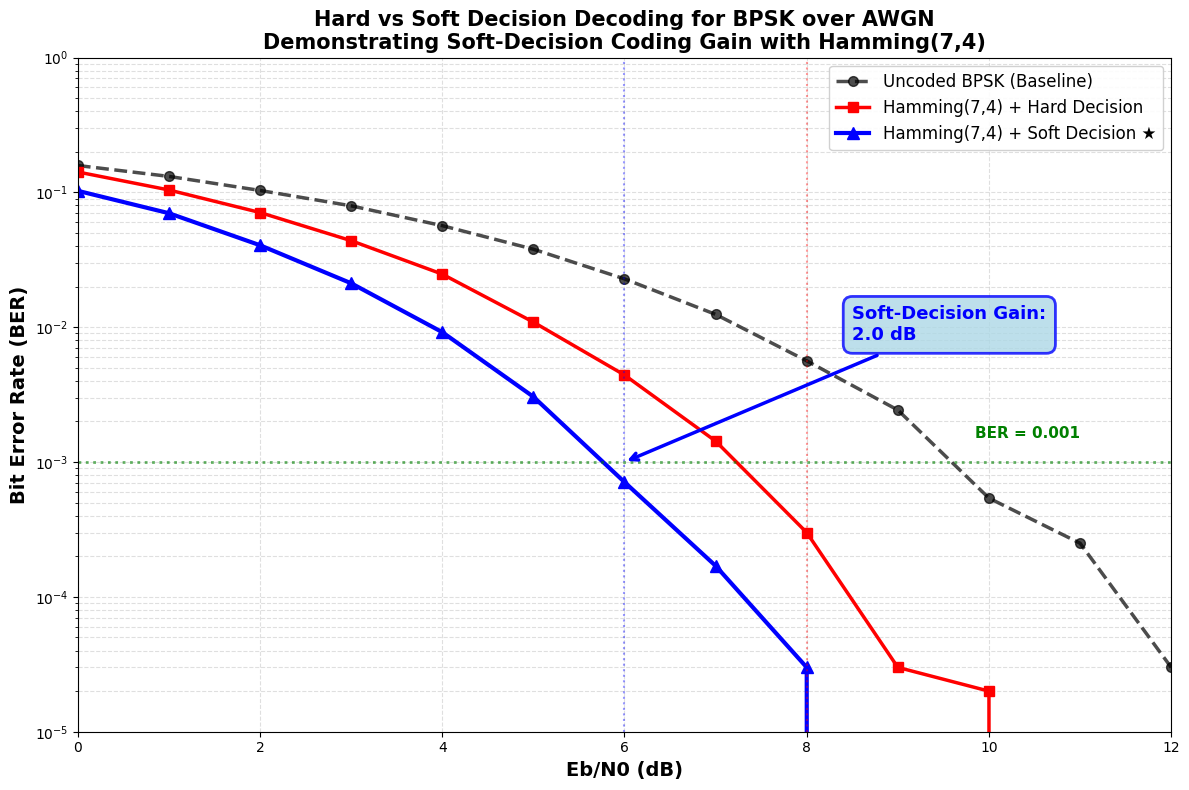

✓ Plot saved as 'step8_hard_vs_soft_ber_curves.png'



In [14]:
num_data_bits = 100000  # Data bits per SNR point (will be padded to multiple of 4)
num_data_bits = (num_data_bits // 4) * 4  # Ensure multiple of 4 for Hamming
SNR_range_dB = np.arange(0, 13, 1)  # 0 to 12 dB in 1 dB steps

print(f"Parameters:")
print(f"  Data bits per SNR point: {num_data_bits}")
print(f"  SNR range: {SNR_range_dB[0]} to {SNR_range_dB[-1]} dB")
print(f"  Total SNR points: {len(SNR_range_dB)}")
print(f"  Channel code: Hamming(7,4) - rate 4/7 = 0.571")
print()

# Storage for results
results = {
    'uncoded_ber': [],
    'coded_hard_ber': [],
    'coded_soft_ber': []
}

print("Running simulations...")
print("-" * 70)

# Run simulation for each SNR point
for i, snr in enumerate(SNR_range_dB):
    print(f"Progress: {i+1}/{len(SNR_range_dB)} | SNR = {snr:2d} dB", end=" | ")

    # Generate random data bits
    np.random.seed(snr + 42)  # Different seed for each SNR, but reproducible
    data_bits = np.random.randint(0, 2, num_data_bits)

    # ========================================
    # SCENARIO 1: UNCODED TRANSMISSION (baseline)
    # ========================================
    symbols_uncoded = bpsk_modulation(data_bits)
    received_uncoded, _ = awgn_channel(symbols_uncoded, snr)
    decoded_uncoded = hard_decision_demodulator(received_uncoded)
    ber_uncoded, _ = calculate_ber(data_bits, decoded_uncoded)
    results['uncoded_ber'].append(ber_uncoded)

    # ========================================
    # SCENARIO 2: CODED WITH HARD DECISION
    # ========================================
    # Encode
    encoded_bits = hamming_encode(data_bits)

    # Modulate
    symbols_coded = bpsk_modulation(encoded_bits)

    # Transmit through channel
    received_coded, noise_power = awgn_channel(symbols_coded, snr)

    # Hard decision demodulation
    received_bits_hard = hard_decision_demodulator(received_coded)

    # Decode with hard decisions
    decoded_hard = hamming_decode_hard(received_bits_hard)

    # Calculate BER (compare only valid decoded bits)
    ber_coded_hard, _ = calculate_ber(data_bits[:len(decoded_hard)], decoded_hard)
    results['coded_hard_ber'].append(ber_coded_hard)

    # ========================================
    # SCENARIO 3: CODED WITH SOFT DECISION
    # ========================================
    # Soft decision demodulation (compute LLRs)
    llr_coded = soft_decision_demodulator(received_coded, noise_power)

    # Decode with soft decisions
    decoded_soft = hamming_decode_soft_ml(llr_coded)

    # Calculate BER
    ber_coded_soft, _ = calculate_ber(data_bits[:len(decoded_soft)], decoded_soft)
    results['coded_soft_ber'].append(ber_coded_soft)

    # Print progress
    print(f"Uncoded: {ber_uncoded:.2e} | Hard: {ber_coded_hard:.2e} | Soft: {ber_coded_soft:.2e}")

print("\n✓ Simulation complete!")
print()

# ============================================
# PLOTTING RESULTS
# ============================================

print("Generating plot...")

plt.figure(figsize=(12, 8))

# Plot all three curves
plt.semilogy(SNR_range_dB, results['uncoded_ber'],
             'k--', linewidth=2.5, marker='o', markersize=7,
             label='Uncoded BPSK (Baseline)', alpha=0.7)

plt.semilogy(SNR_range_dB, results['coded_hard_ber'],
             'r-', linewidth=2.5, marker='s', markersize=7,
             label='Hamming(7,4) + Hard Decision')

plt.semilogy(SNR_range_dB, results['coded_soft_ber'],
             'b-', linewidth=3, marker='^', markersize=8,
             label='Hamming(7,4) + Soft Decision ★', markerfacecolor='blue')

# Grid and labels
plt.grid(True, which='both', linestyle='--', alpha=0.4)
plt.xlabel('Eb/N0 (dB)', fontsize=14, fontweight='bold')
plt.ylabel('Bit Error Rate (BER)', fontsize=14, fontweight='bold')
plt.title('Hard vs Soft Decision Decoding for BPSK over AWGN\n' +
          'Demonstrating Soft-Decision Coding Gain with Hamming(7,4)',
          fontsize=15, fontweight='bold')
plt.legend(fontsize=12, loc='upper right', framealpha=0.9)
plt.ylim([1e-5, 1])
plt.xlim([SNR_range_dB[0], SNR_range_dB[-1]])

# ============================================
# CALCULATE AND ANNOTATE CODING GAIN
# ============================================

target_ber = 1e-3
try:
    # Find SNR where each method achieves target BER
    idx_hard = np.where(np.array(results['coded_hard_ber']) < target_ber)[0][0]
    idx_soft = np.where(np.array(results['coded_soft_ber']) < target_ber)[0][0]

    snr_hard = SNR_range_dB[idx_hard]
    snr_soft = SNR_range_dB[idx_soft]

    coding_gain = snr_hard - snr_soft

    # Add reference line at target BER
    plt.axhline(y=target_ber, color='green', linestyle=':', linewidth=2, alpha=0.6)
    plt.text(SNR_range_dB[-1] - 1, target_ber * 1.5, f'BER = {target_ber}',
             fontsize=11, ha='right', color='green', fontweight='bold')

    # Annotate the gain
    plt.annotate(f'Soft-Decision Gain:\n{coding_gain:.1f} dB',
                xy=(snr_soft, target_ber),
                xytext=(snr_soft + 2.5, target_ber * 8),
                arrowprops=dict(arrowstyle='->', color='blue', lw=2.5),
                fontsize=13, color='blue', fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue',
                         edgecolor='blue', linewidth=2, alpha=0.8))

    # Add vertical lines showing SNR difference
    plt.axvline(x=snr_hard, color='red', linestyle=':', alpha=0.4, linewidth=1.5)
    plt.axvline(x=snr_soft, color='blue', linestyle=':', alpha=0.4, linewidth=1.5)

except IndexError:
    print("⚠ Warning: Could not calculate coding gain at target BER")
    coding_gain = np.nan

# Save figure
plt.tight_layout()
plt.savefig("step8_hard_vs_soft_ber_curves.png", dpi=300, bbox_inches='tight')
plt.show()

print("✓ Plot saved as 'step8_hard_vs_soft_ber_curves.png'")
print()